<a href="https://colab.research.google.com/github/SahilK-027/Deep-Learning-with-PyTorch/blob/main/ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-v80noyye
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-v80noyye
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 34.56 MiB/s, done.
Resolving deltas: 100% (3/3), done.


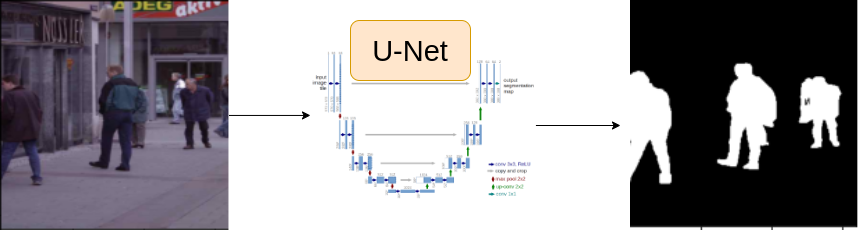

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
csv_file = "/content/Human-Segmentation-Dataset-master/train.csv"
data_dir = "/content/"

DEVICE = 'cuda'

EPOCHS = 25
#leaning rate
LR = 0.003
IMG_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [ ]:
df = pd.read_csv(csv_file)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row = df.iloc[19]

image_path = row.images
mask_path = row.masks
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

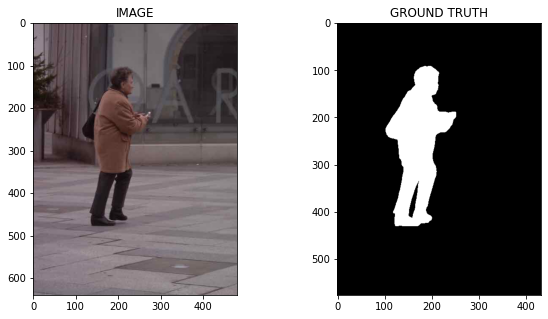

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df,valid_df = train_test_split(df, test_size=0.2, random_state = 42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
from albumentations.augmentations.geometric.transforms import VerticalFlip
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ])
def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
  ])


# Task 4 : Create Custom Dataset 

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):
  def __init__(self,df,augmentations):
    self.df = df
    self.augmentations = augmentations
  def __len__(self):
    return len(self.df)
  def __getitem__(self,index):
    row = self.df.iloc[index]
    image_path = row.images
    mask_path = row.masks
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    #(height, width, channel)
    mask = np.expand_dims(mask,axis = -1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']
    #(height, width, channel) -> (channel, height, width)
    #(0,       1,      2.   ) -> (2,        1,        0 )
    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    # converting numpy to tensor
    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


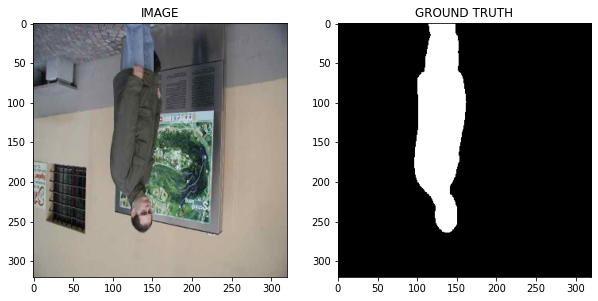

In [ ]:
index = 34

image, mask = trainset[index]
helper.show_image(image,mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle= True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [ ]:
print(f"Total number of batches in trainloader : {len(trainloader)}")
print(f"Total number of batches in validloader : {len(validloader)}")

Total number of batches in trainloader : 15
Total number of batches in validloader : 4


In [ ]:
for image, mask in trainloader:
  break
print(f"One batch image size : {image.shape}")
print(f"One batch mask size : {mask.shape}")

One batch image size : torch.Size([16, 3, 320, 320])
One batch mask size : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel (nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()
    self.arc = smp.Unet(
        encoder_name= ENCODER,
        encoder_weights= WEIGHTS,
        in_channels= 3,
        classes =1,
        activation = None
    )
  def forward(self, images, masks = None):
    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode = 'binary')(logits,masks)
      loss2 = nn.BCEWithLogitsLoss()(logits,masks)
      return logits, loss1+loss2
    
    return logits

In [ ]:
model = SegmentationModel();
model.to(DEVICE);

# Task 7 : Create Train and Validation Function 

In [ ]:
def train_fn(data_loader, model, optimizer):
  model.train()
  total_loss = 0.0
  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss= model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  return total_loss / len(data_loader)

In [ ]:
def eval_fn(data_loader, model):
  model.eval()
  total_loss = 0.0
  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss= model(images, masks)

      total_loss += loss.item()
    return total_loss / len(data_loader)

# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr = LR)

In [ ]:
best_valid_loss = np.Inf
for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)
  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(),'best_model.pt')
    print("SAVED-MODEL")
    best_valid_loss = valid_loss
  print(f"EPOCH : {i+1} Train_loss: {train_loss} valid_loss: {valid_loss}")

100%|██████████| 4/4 [00:00<00:00,  4.99it/s]


SAVED-MODEL
EPOCH : 1 Train_loss: 0.25215722223122916 valid_loss: 0.33664653450250626


100%|██████████| 4/4 [00:00<00:00,  4.96it/s]


SAVED-MODEL
EPOCH : 2 Train_loss: 0.2617827077706655 valid_loss: 0.2752856910228729


100%|██████████| 4/4 [00:00<00:00,  5.06it/s]


SAVED-MODEL
EPOCH : 3 Train_loss: 0.26462344427903495 valid_loss: 0.23731132224202156


100%|██████████| 4/4 [00:00<00:00,  4.94it/s]


EPOCH : 4 Train_loss: 0.18861782252788545 valid_loss: 0.27283066883683205


100%|██████████| 4/4 [00:00<00:00,  5.05it/s]


SAVED-MODEL
EPOCH : 5 Train_loss: 0.20601234634717305 valid_loss: 0.2108221799135208


100%|██████████| 4/4 [00:00<00:00,  5.01it/s]


EPOCH : 6 Train_loss: 0.18870148211717605 valid_loss: 0.2143939658999443


100%|██████████| 4/4 [00:00<00:00,  5.02it/s]


SAVED-MODEL
EPOCH : 7 Train_loss: 0.17297257681687672 valid_loss: 0.19979840889573097


100%|██████████| 4/4 [00:00<00:00,  5.00it/s]


EPOCH : 8 Train_loss: 0.158950245877107 valid_loss: 0.23385677486658096


100%|██████████| 4/4 [00:00<00:00,  5.02it/s]


EPOCH : 9 Train_loss: 0.15054106762011846 valid_loss: 0.23262504488229752


100%|██████████| 4/4 [00:00<00:00,  4.98it/s]


EPOCH : 10 Train_loss: 0.17608577410380047 valid_loss: 0.21188828349113464


100%|██████████| 4/4 [00:00<00:00,  4.93it/s]


EPOCH : 11 Train_loss: 0.18312064011891682 valid_loss: 0.2259822115302086


100%|██████████| 4/4 [00:00<00:00,  4.99it/s]


SAVED-MODEL
EPOCH : 12 Train_loss: 0.12571231524149576 valid_loss: 0.1817860584706068


100%|██████████| 4/4 [00:00<00:00,  4.96it/s]


EPOCH : 13 Train_loss: 0.11750505814949672 valid_loss: 0.22207457199692726


100%|██████████| 4/4 [00:00<00:00,  4.96it/s]


EPOCH : 14 Train_loss: 0.16761806805928547 valid_loss: 0.24437215924263


100%|██████████| 4/4 [00:00<00:00,  4.93it/s]


EPOCH : 15 Train_loss: 0.16222883462905885 valid_loss: 0.2360268011689186


100%|██████████| 4/4 [00:00<00:00,  5.03it/s]


EPOCH : 16 Train_loss: 0.14457788268725077 valid_loss: 0.2545884922146797


100%|██████████| 4/4 [00:00<00:00,  4.98it/s]


EPOCH : 17 Train_loss: 0.15243339935938519 valid_loss: 0.22851372323930264


100%|██████████| 4/4 [00:00<00:00,  4.95it/s]


EPOCH : 18 Train_loss: 0.1510089948773384 valid_loss: 0.20733745582401752


100%|██████████| 4/4 [00:00<00:00,  4.91it/s]


SAVED-MODEL
EPOCH : 19 Train_loss: 0.14829844782749813 valid_loss: 0.179891224950552


100%|██████████| 4/4 [00:00<00:00,  4.92it/s]


EPOCH : 20 Train_loss: 0.13557814011971156 valid_loss: 0.19778694584965706


100%|██████████| 4/4 [00:00<00:00,  4.99it/s]


EPOCH : 21 Train_loss: 0.10402040133873622 valid_loss: 0.21640649065375328


100%|██████████| 4/4 [00:00<00:00,  5.03it/s]


SAVED-MODEL
EPOCH : 22 Train_loss: 0.10663537234067917 valid_loss: 0.16771217063069344


100%|██████████| 4/4 [00:00<00:00,  5.03it/s]


EPOCH : 23 Train_loss: 0.09448071221510569 valid_loss: 0.171684380620718


100%|██████████| 4/4 [00:00<00:00,  5.01it/s]


EPOCH : 24 Train_loss: 0.0838081066807111 valid_loss: 0.1933668740093708


100%|██████████| 4/4 [00:00<00:00,  5.00it/s]


SAVED-MODEL
EPOCH : 25 Train_loss: 0.0868550956249237 valid_loss: 0.16439396888017654


# Task 9 : Inference

In [ ]:
index = 20
model.load_state_dict(torch.load('/content/best_model.pt'))
image, mask = validset[index]
logits_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) *1

In [ ]:
print(mask)
print(pred_mask)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]], device='cuda:0')


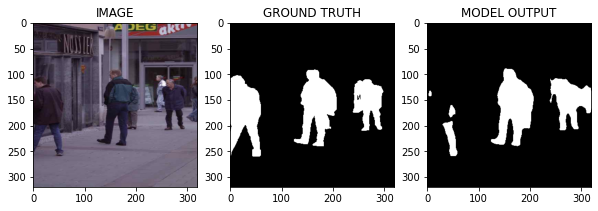

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))